In [ ]:
from datetime import datetime
import random 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/gdrive


In [ ]:
def con2bin(label):
  if label in ['Psoriasis', 'Chicken pox', 'Impetigo', 'Acne']:
    return 1
  return 0

In [ ]:
def get_raw_data(dir_name):
    #  load data
    data = pd.read_csv('{}Symptom2Disease.csv'.format(dir_name), encoding = 'latin-1', usecols=['text', 'label'])
    data['label'] =  data['label'].apply(con2bin)
    return data

raw_data = get_raw_data(dir_name + 'datasets/')
raw_data

,label,text
0,1,I have been experiencing a skin rash on my arm...
1,1,"My skin has been peeling, especially on my kne..."
2,1,I have been experiencing joint pain in my fing...
3,1,"There is a silver like dusting on my skin, esp..."
4,1,"My nails have small dents or pits in them, and..."
...,...,...
1195,0,I'm shaking and trembling all over. I've lost ...
1196,0,"Particularly in the crevices of my skin, I hav..."
1197,0,I regularly experience these intense urges and...
1198,0,"I have trouble breathing, especially outside. ..."


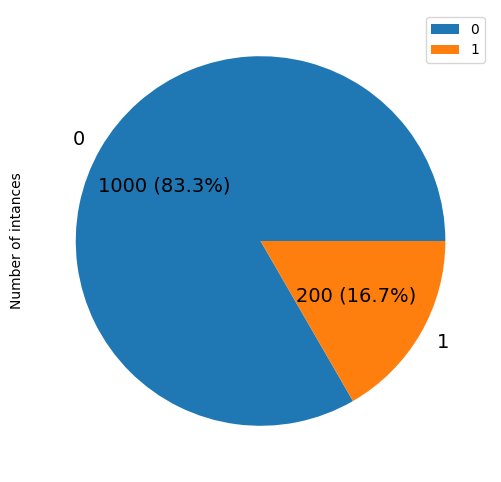

In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of intances': [data['label'].value_counts()[0], data['label'].value_counts()[1]]}
    df = pd.DataFrame(dataset_statistics, index=['0', '1'])
    df.plot(kind='pie', y='Number of intances', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))
    
get_dataset_statistics(raw_data)

In [ ]:
raw_data['text'].is_unique

False

In [ ]:
raw_data.drop_duplicates( inplace=True)
raw_data['text'].is_unique

True

In [ ]:
raw_data

,label,text
0,1,I have been experiencing a skin rash on my arm...
1,1,"My skin has been peeling, especially on my kne..."
2,1,I have been experiencing joint pain in my fing...
3,1,"There is a silver like dusting on my skin, esp..."
4,1,"My nails have small dents or pits in them, and..."
...,...,...
1195,0,I'm shaking and trembling all over. I've lost ...
1196,0,"Particularly in the crevices of my skin, I hav..."
1197,0,I regularly experience these intense urges and...
1198,0,"I have trouble breathing, especially outside. ..."


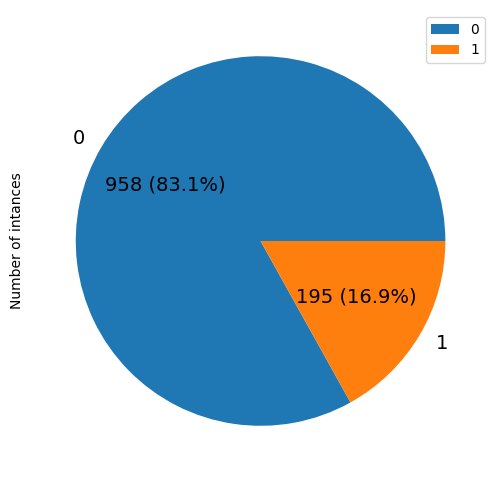

In [ ]:
get_dataset_statistics(raw_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(raw_data['text'].to_numpy(), raw_data['label'].to_numpy(), stratify=raw_data['label'].to_numpy(), test_size=0.2, random_state=24)

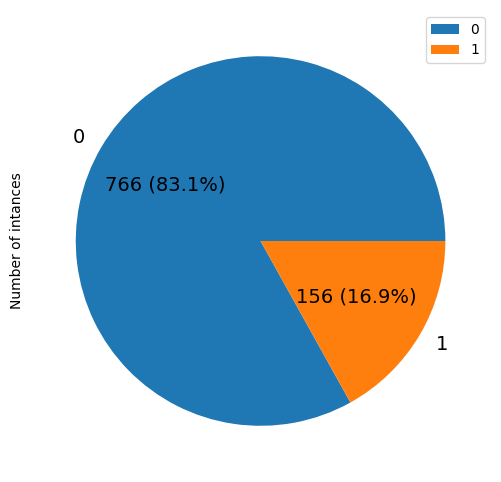

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_train}))

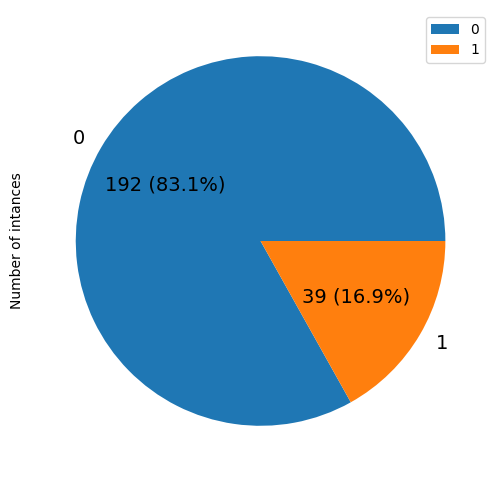

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_test}))

In [ ]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
train_data

,text,label
0,I am quite queasy and dizzy when I have a temp...,0
1,I've been experiencing muscular weakness and s...,0
2,"Over the last week, the rash on my face has go...",1
3,I have a frequent need to urinate and often ha...,0
4,I am feeling quite weak. I'm having a lot of s...,0
...,...,...
917,Sometimes my skin starts to flake off from my ...,0
918,My skin has a horrible rash that is absolutely...,1
919,I occasionally have burning in my upper abdome...,0
920,I lose weight unintentionally and find it chal...,0


In [ ]:
test_data = pd.DataFrame({'text': X_test, 'label': y_test})
test_data

,text,label
0,My cheeks and nose are covered with red sores....,1
1,"My vision is blurry, and it feels like it's ge...",0
2,I have noticed a sudden peeling of skin at dif...,1
3,I've been suffering from severe constipation l...,0
4,The sores around my nose are now surrounded by...,1
...,...,...
226,I have been feeling nauseous and have a consta...,0
227,I have a sour acidic taste in my mouth. I have...,0
228,I routinely experience heartburn and indigesti...,0
229,The veins on my calves have become very promin...,0


# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def text_preprocessing(raw_text):
  text_words = raw_text.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(text_words.lower())
  filtered_text = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_text)

In [ ]:
train_data = train_data[['text', 'label']].copy()

train_data['text'] = train_data['text'].apply(text_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,quite queasy dizzy temperature brain completel...,0
1,ive experiencing muscular weakness stiffness n...,0
2,week rash face gotten severe painful sores beg...,1
3,frequent need urinate uncontrollable urges fee...,0
4,feeling quite weak im lot stomach discomfort c...,0
...,...,...
917,skin starts flake rashes im prone sick result ...,0
918,skin horrible rash absolutely nonheritable bla...,1
919,occasionally burning upper abdomen day night h...,0
920,lose weight unintentionally challenging acquir...,0


In [ ]:
test_data = test_data[['text', 'label']].copy()

test_data['text'] = test_data['text'].apply(text_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,cheeks nose covered red sores ive observed ras...,1
1,vision blurry feels like getting worse time fe...,0
2,noticed sudden peeling skin different parts bo...,1
3,ive suffering severe constipation lately restr...,0
4,sores nose surrounded red inflamed skin rash c...,1
...,...,...
226,feeling nauseous constant urge vomit strong pa...,0
227,sour acidic taste mouth frequent belching burp...,0
228,routinely experience heartburn indigestion par...,0
229,veins calves prominent causing discomfort stan...,0


# Feature Extraction

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(text) for text in test_data['text'].values]))

In [ ]:
X_test.shape

(231, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(231,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Skin Diseases/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score),
                                                                       'Precision': make_scorer(precision_score)
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    f1score = f1_score(test_labels, y_pred)
    f2score = fbeta_score(y_test, y_pred, beta=2)

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [50, 75, 100, 150, 200], 'max_features': [8, 9, 10], 'min_samples_split': [25, 30], 'criterion': ['gini','entropy'], 'max_depth': [4, 5]}]
        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf', 'poly'], 'degree': [2, 3 , 4, 5, 6, 7]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

#Text Aug.

In [ ]:
from nltk.corpus import wordnet

def get_synonyms(word):
  synonyms = []
  for synonym in wordnet.synsets(word):
    for lemma in [l.name().lower() for l in synonym.lemmas()]:
      if len(lemma.split('_')) == 1 and lemma != word:
        synonyms.append(lemma)

  return list(set(synonyms))

In [ ]:
import itertools

def get_sentence_augmentations(sentence, similarity_threshold=.75):
  sentence_tokens = word_tokenize(sentence.lower())
  new_sentences = []
  words = []
  all_synonyms = []
  for word in sentence_tokens:
    if word in word2vec_model.key_to_index :
      synonyms = get_synonyms(word)
      if len(synonyms) > 0:
        good_synonyms = []
        for synonym in synonyms:
          if synonym in word2vec_model.key_to_index :
            if word2vec_model.similarity(word, synonym) >= similarity_threshold:
              good_synonyms.append(synonym)
        if len(good_synonyms) > 0:
          words.append(word)
          good_synonyms.append(word)
          all_synonyms.append(good_synonyms)
  for product in itertools.product(*all_synonyms):
    new_sentence = sentence
    for src, dest in zip(words, product):
        new_sentence = new_sentence.replace("%s" % src, dest)
    new_sentences.append(new_sentence.lower())
    # new_sentences.remove(sentence)
  return new_sentences

In [ ]:
def my_augmentation(prepro_dataset, lable, similarity_threshold=.75):
  texts = prepro_dataset.loc[prepro_dataset['label'] == lable]['text'].values
  texts_num = len(texts)
  new_texts = []
  i = 0
  
  for text in texts:
    new_texts.extend(get_sentence_augmentations(text, similarity_threshold))
    if i % 20 == 0:
      print(f" {int(100*i/texts_num)} %")
    i += 1
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

In [ ]:
augmented_dataset = my_augmentation(train_data, lable=1, similarity_threshold=.75)

 0 %
 12 %
 25 %
 38 %
 51 %
 64 %
 77 %
 90 %


<ipython-input-20-98b0f6d823b3>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
652,im dripping perspiration catch breath throat f...,0
952,skin rash thats red inflamed spread body ive e...,1
826,pain persistent cough numbness arms legs bothe...,0
1138,im feeling really nauseous uneasy im sure ive ...,1
1209,high fever red spots rashes body feeling exhau...,1
...,...,...
845,throat feels food acid backing lying makes che...,0
1378,im really exhausted lacking energy scarcely ey...,1
15,ive scratchy stomach throwing aside losing wei...,0
268,intense scratching chills nausea high fever iv...,0


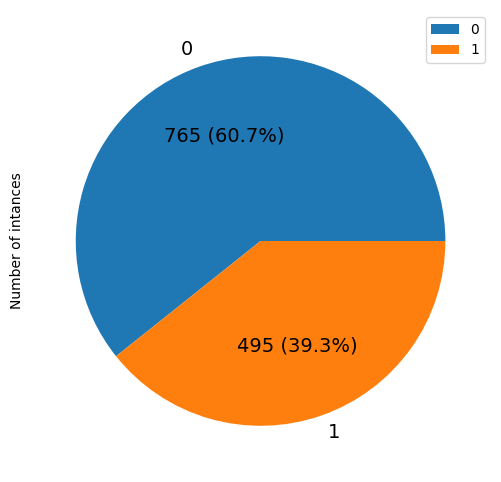

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in augmented_dataset['text'].values]))

In [ ]:
aug_X_train.shape

(1260, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(1260,)

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

#Random Forest

train accuracy = 0.9857142857142858
test accuracy = 0.922077922077922
Recall = 0.7948717948717948
Precision = 0.7560975609756098
F1 score = 0.7749999999999999
F2 score = 0.7868020304568527
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       192
           1       0.76      0.79      0.77        39

    accuracy                           0.92       231
   macro avg       0.86      0.87      0.86       231
weighted avg       0.92      0.92      0.92       231



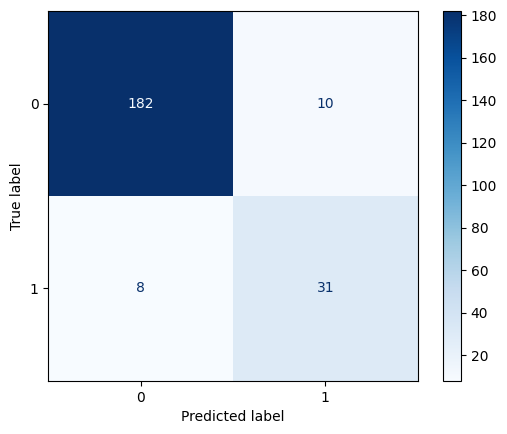

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 9, 'min_samples_split': 25, 'n_estimators': 200}


(0.7749999999999999, 0.7868020304568527)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TDAS_RF')

#SVM

train accuracy = 0.9968253968253968
test accuracy = 0.9653679653679653
Recall = 0.9230769230769231
Precision = 0.8780487804878049
F1 score = 0.9
F2 score = 0.9137055837563454
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       192
           1       0.88      0.92      0.90        39

    accuracy                           0.97       231
   macro avg       0.93      0.95      0.94       231
weighted avg       0.97      0.97      0.97       231



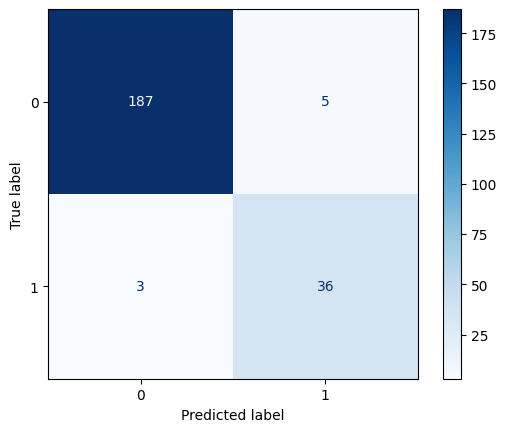

{'degree': 6, 'kernel': 'poly'}


(0.9, 0.9137055837563454)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TDAS_SVM')

In [ ]:
evaluation_metrics_aug

,Recall,Precision,F1 score,F2 score
RandomForest,0.794872,0.756098,0.775,0.786802
SVM,0.923077,0.878049,0.9,0.913706


#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import StratifiedKFold

In [ ]:
text_words_lengths = [len(raw_data.loc[i]['text'].split()) for i in raw_data.index ]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))

In [ ]:
def create_blstm_model(sent_length, words_mean, train_texts):

  text_vec = layers.TextVectorization( 
    max_tokens=sent_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=words_mean
  )

  text_vec.adapt(train_texts)

  embedding_layer = layers.Embedding(
    input_dim=sent_length,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=words_mean
  )

  input_layer = layers.Input(shape=(1,), dtype=tf.string) 

  vec_layer = text_vec(input_layer)
  embedding_layer_model = embedding_layer(vec_layer) 

  bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer = L1L2(l1=0.01, l2=0.0)))(embedding_layer_model) 

  flatten = layers.Flatten()(bi_lstm) 
  dropout = layers.Dropout(.1)(flatten) 

  x = layers.Dense(32, activation='relu')(dropout) 

  output_layer = layers.Dense(1, activation='sigmoid')(x) 

  blstm_model = keras.Model(input_layer, output_layer) 

  blstm_model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])  
  
  return blstm_model

# Cross Validation

In [ ]:
def cv_blstm(sent_length, words_mean):

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(sent_length, words_mean, train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))

    f1_sc = f1_score(test_labels, y_pred)
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='binary')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm(total_length, text_words_mean)

Fold 0
Epoch 1/10
71/71 [==============================] - 18s 126ms/step - loss: 22.8966 - accuracy: 0.8492 - val_loss: 8.1880 - val_accuracy: 0.9683
Epoch 2/10
71/71 [==============================] - 2s 24ms/step - loss: 2.5015 - accuracy: 0.9859 - val_loss: 0.3564 - val_accuracy: 0.9762
Epoch 3/10
71/71 [==============================] - 1s 19ms/step - loss: 0.2775 - accuracy: 0.9938 - val_loss: 0.2539 - val_accuracy: 0.9921
Epoch 4/10
71/71 [==============================] - 1s 13ms/step - loss: 0.1409 - accuracy: 0.9982 - val_loss: 0.4186 - val_accuracy: 0.9524
Epoch 5/10
71/71 [==============================] - 1s 14ms/step - loss: 0.1680 - accuracy: 0.9929 - val_loss: 0.4025 - val_accuracy: 0.9444
Epoch 6/10
71/71 [==============================] - 1s 11ms/step - loss: 0.1144 - accuracy: 0.9991 - val_loss: 0.0951 - val_accuracy: 1.0000
Epoch 7/10
71/71 [==============================] - 1s 12ms/step - loss: 0.1359 - accuracy: 0.9965 - val_loss: 0.1617 - val_accuracy: 0.9762
Epo

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,1.0,0.960784,0.98,0.991903
1,1.0,0.98,0.989899,0.995935
2,1.0,0.960784,0.98,0.991903
3,1.0,0.98,0.989899,0.995935
4,1.0,0.960784,0.98,0.991903
5,1.0,1.0,1.0,1.0
6,0.98,1.0,0.989899,0.983936
7,1.0,0.980392,0.990099,0.996016
8,0.98,1.0,0.989899,0.983936
9,1.0,1.0,1.0,1.0


In [ ]:
cv_results.mean()

Recall       0.996000
Precision    0.982275
F1 score     0.988969
F2 score     0.993147
dtype: float64

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(1260, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(1260, 1)

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
y_test = test_data['label'].values

In [ ]:
def train_blstm(sent_length, words_mean, train_texts, train_labels):

  blstm_model = create_blstm_model(sent_length, words_mean, train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(X_test, y_test))
  
  blstm_model.evaluate(X_test, y_test)
  y_pred = np.round(blstm_model.predict(X_test))

  f1_sc = f1_score(y_test, y_pred)
  f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')


  print("test accuracy = " + str(accuracy_score(y_test, y_pred)))
  print("Recall = {}".format(recall_score(y_test, y_pred)))
  print("Precision = {}".format(precision_score(y_test, y_pred)))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc

Epoch 1/10
79/79 [==============================] - 11s 84ms/step - loss: 21.4190 - accuracy: 0.8405 - val_loss: 6.1303 - val_accuracy: 0.9697
Epoch 2/10
79/79 [==============================] - 2s 26ms/step - loss: 1.5659 - accuracy: 0.9873 - val_loss: 0.2895 - val_accuracy: 0.9567
Epoch 3/10
79/79 [==============================] - 2s 22ms/step - loss: 0.1719 - accuracy: 0.9944 - val_loss: 0.2327 - val_accuracy: 0.9827
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.1589 - accuracy: 0.9952 - val_loss: 0.3413 - val_accuracy: 0.9870
Epoch 5/10
79/79 [==============================] - 1s 10ms/step - loss: 0.1596 - accuracy: 0.9992 - val_loss: 0.1272 - val_accuracy: 0.9870
Epoch 6/10
79/79 [==============================] - 1s 13ms/step - loss: 0.1229 - accuracy: 0.9992 - val_loss: 0.1386 - val_accuracy: 0.9870
Epoch 7/10
79/79 [==============================] - 1s 10ms/step - loss: 0.0887 - accuracy: 1.0000 - val_loss: 0.1334 - val_accuracy: 0.9784
Epoch 8/10


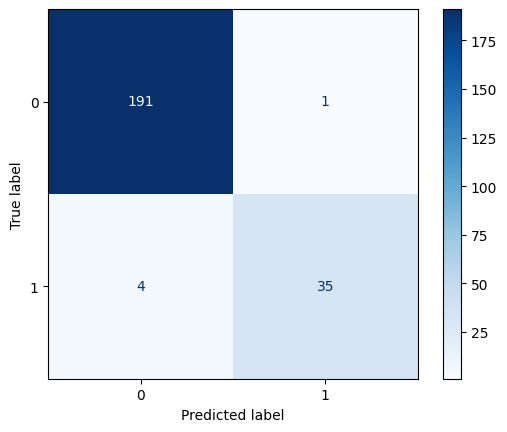

0.9333333333333333

In [ ]:
train_blstm(total_length, text_words_mean, aug_X_train, aug_y_train)

Epoch 1/10
79/79 [==============================] - 10s 85ms/step - loss: 21.2679 - accuracy: 0.8500 - val_loss: 6.0873 - val_accuracy: 0.9481
Epoch 2/10
79/79 [==============================] - 2s 22ms/step - loss: 1.5359 - accuracy: 0.9873 - val_loss: 0.2582 - val_accuracy: 0.9697
Epoch 3/10
79/79 [==============================] - 1s 19ms/step - loss: 0.1818 - accuracy: 0.9937 - val_loss: 0.2093 - val_accuracy: 0.9827
Epoch 4/10
79/79 [==============================] - 1s 15ms/step - loss: 0.1699 - accuracy: 0.9944 - val_loss: 0.2896 - val_accuracy: 0.9654
Epoch 5/10
79/79 [==============================] - 1s 14ms/step - loss: 0.1169 - accuracy: 0.9992 - val_loss: 0.1262 - val_accuracy: 0.9870
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.1883 - accuracy: 0.9952 - val_loss: 0.3207 - val_accuracy: 0.9827
Epoch 7/10
79/79 [==============================] - 1s 14ms/step - loss: 0.1490 - accuracy: 1.0000 - val_loss: 0.1462 - val_accuracy: 0.9784
Epoch 8/10


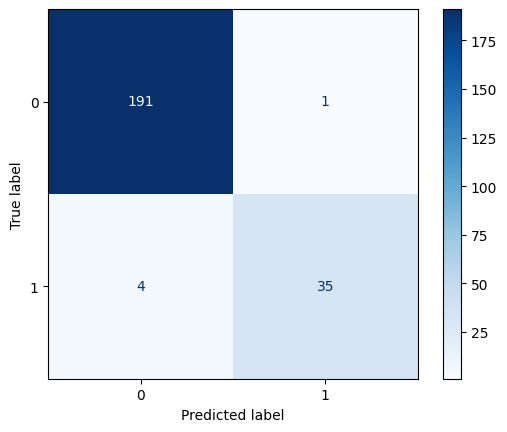

0.9333333333333333

In [ ]:
train_blstm(total_length, text_words_mean, aug_X_train, aug_y_train)